In [41]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchinfo import summary

import os
import time
import datetime as dt
from netCDF4 import Dataset as nc_Dataset
import pandas as pd
import numpy as np
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from HRRR_URMA_Datasets import *
from SR_UNet_simple import *
from utils import *

torch.manual_seed(42)

In [2]:
# For comparison, need to be careful with datasets, 
# as the normalization differs, so models can only be compared on their OWN appropriately-normalized dataset!

In [3]:
BATCH_SIZE = 64 
NUM_EPOCHS = 2000

In [4]:
MONTHS_model_1 = [1,3]
DAYS_model_1 = [1,31] #make sure last entry matches number of days in month[1]...

MONTHS_model_2 = [1,3]
DAYS_model_2 = [1,31] #make sure last entry matches number of days in month[1]...

HOUR = 0  # 0 --> use only 00z data; 12 --> only 12z data

In [5]:
# Pay attention to details of terrain!
# These are bools, but write as ints for ease of string formatting later
W_HRRR_T_model_1 = 1
W_URMA_T_model_1 = 1
W_DIFF_T_model_1 = 1

W_HRRR_T_model_2 = 1
W_URMA_T_model_2 = 1
W_DIFF_T_model_2 = 1

In [6]:
pred_model_1_name = f"UNSim_BS{BATCH_SIZE}_NE{NUM_EPOCHS}_{str(HOUR).zfill(2)}z_months{MONTHS_model_1[0]}-{MONTHS_model_1[1]}_tHRRR{W_HRRR_T_model_1}_tURMA{W_URMA_T_model_1}_tDIFF{W_DIFF_T_model_1}"
n_ch_in_model_1 = 1+W_HRRR_T_model_1+W_URMA_T_model_1+W_DIFF_T_model_1

#pred_model_2_name = f"UNSim_BS{BATCH_SIZE}_NE{NUM_EPOCHS}_{str(HOUR).zfill(2)}z_months{MONTHS_model_2[0]}-{MONTHS_model_2[1]}_tHRRR{W_HRRR_T_model_2}_tURMA{W_URMA_T_model_2}_tDIFF{W_DIFF_T_model_2}"
pred_model_2_name = f"UNSim_BS{BATCH_SIZE}_NE{NUM_EPOCHS}_{str(HOUR).zfill(2)}z_months{MONTHS_model_2[0]}-{MONTHS_model_2[1]}_tHRRR{W_HRRR_T_model_2}_tURMA{W_URMA_T_model_2}_tDIFF{W_DIFF_T_model_2}_OneTerrainNorm"
n_ch_in_model_2 = 1+W_HRRR_T_model_2+W_URMA_T_model_2+W_DIFF_T_model_2

In [7]:
# Pay attention to details of terrain!

train_ds_model_1 = HRRR_URMA_Dataset_Anytime_Anydate_Anyterrain(is_train=True,
                                                                with_hrrr_terrain=W_HRRR_T_model_1,
                                                                with_urma_terrain=W_URMA_T_model_1,
                                                                with_terrain_difference=W_DIFF_T_model_1,
                                                                months=MONTHS_model_1,
                                                                days=DAYS_model_1,
                                                                hour=HOUR)

train_ds_model_2 = HRRR_URMA_Dataset_Anytime_Anydate_Anyterrain(is_train=True,
                                                                with_hrrr_terrain=W_HRRR_T_model_2,
                                                                with_urma_terrain=W_URMA_T_model_2,
                                                                with_terrain_difference=W_DIFF_T_model_2,
                                                                months=MONTHS_model_2,
                                                                days=DAYS_model_2,
                                                                hour=HOUR)

00z data selected
Done making date index list. Months = 1 to 3, days = 1 to 31
Done with normalization
Done restricting xarrays to date indices
00z data selected
Done making date index list. Months = 1 to 3, days = 1 to 31
Done with normalization
Done restricting xarrays to date indices


In [8]:
# Load previously trained model 1
pred_model_1 = SR_UNet_simple(n_channels_in=n_ch_in_model_1)
pred_model_1.load_state_dict(torch.load(f"/scratch/RTMA/alex.schein/hrrr_CNN_testing/Trained models/{pred_model_1_name}.pt", weights_only=True))
device = "cuda:1"

pred_model_1.to(device)

SR_UNet_simple(
  (first_conv): FirstConv(
    (conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (second_conv): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (enc_1): Encoder(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
    )
  )
  (enc_2): Encoder(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(5, 5), strid

In [9]:
# Load previously trained model 2
pred_model_2 = SR_UNet_simple(n_channels_in=n_ch_in_model_2)
pred_model_2.load_state_dict(torch.load(f"/scratch/RTMA/alex.schein/hrrr_CNN_testing/Trained models/{pred_model_2_name}.pt", weights_only=True))
device = "cuda:1"

pred_model_2.to(device)

SR_UNet_simple(
  (first_conv): FirstConv(
    (conv): Sequential(
      (0): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1), padding=same, bias=False)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (second_conv): ConvBlock(
    (conv): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
      (1): LeakyReLU(negative_slope=0.1, inplace=True)
    )
  )
  (enc_1): Encoder(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=same)
          (1): LeakyReLU(negative_slope=0.1, inplace=True)
        )
      )
    )
  )
  (enc_2): Encoder(
    (encoder): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): ConvBlock(
        (conv): Sequential(
          (0): Conv2d(128, 256, kernel_size=(5, 5), strid

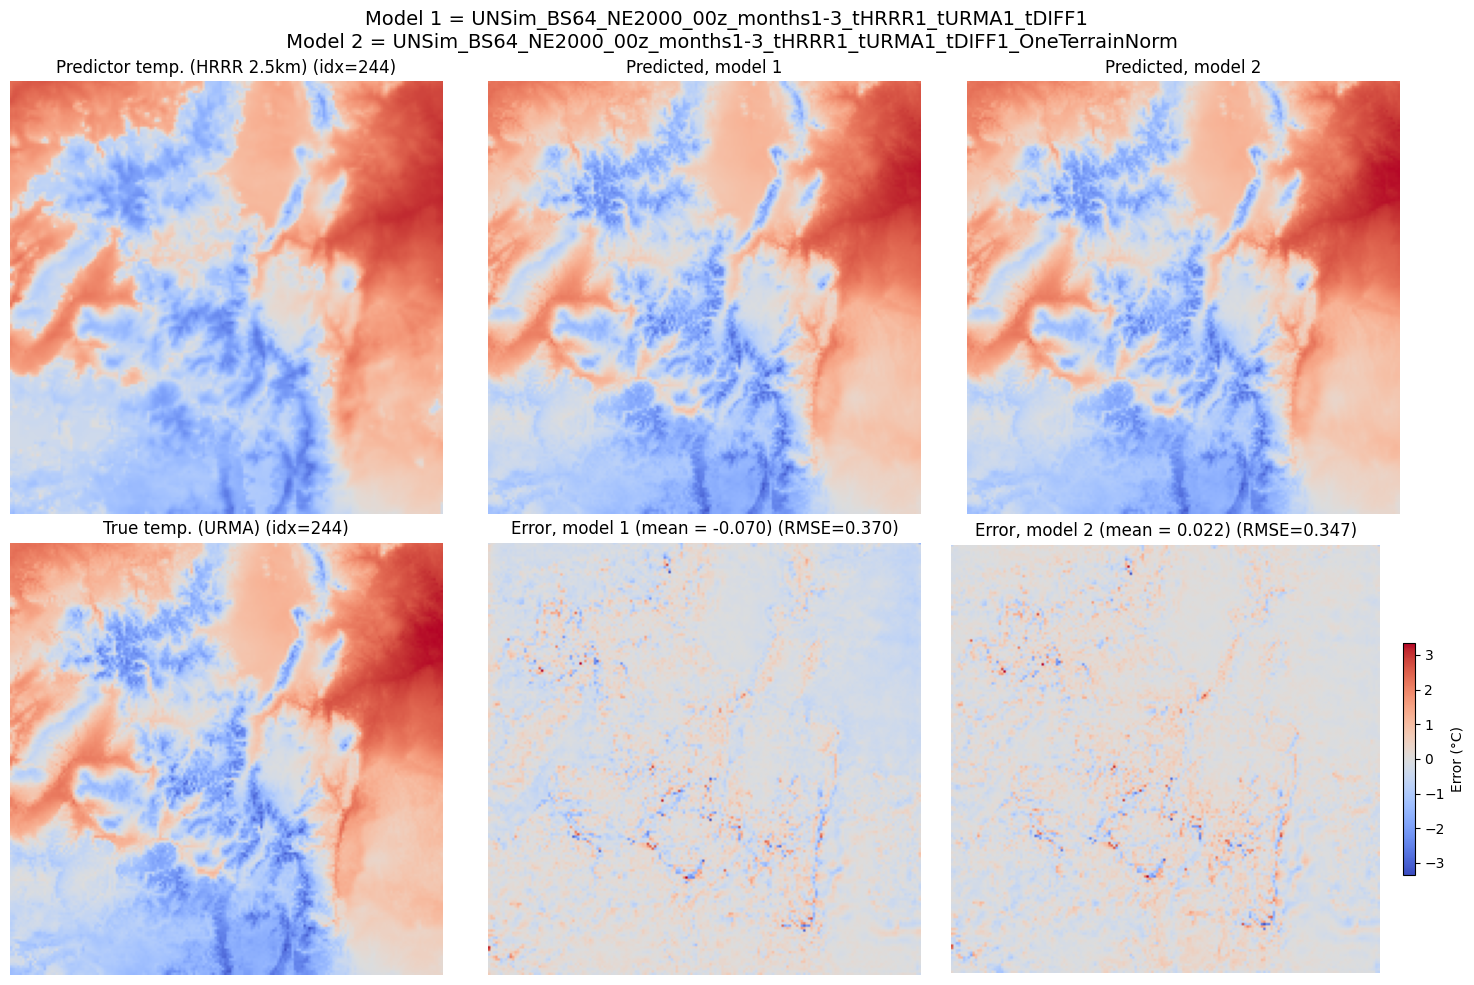

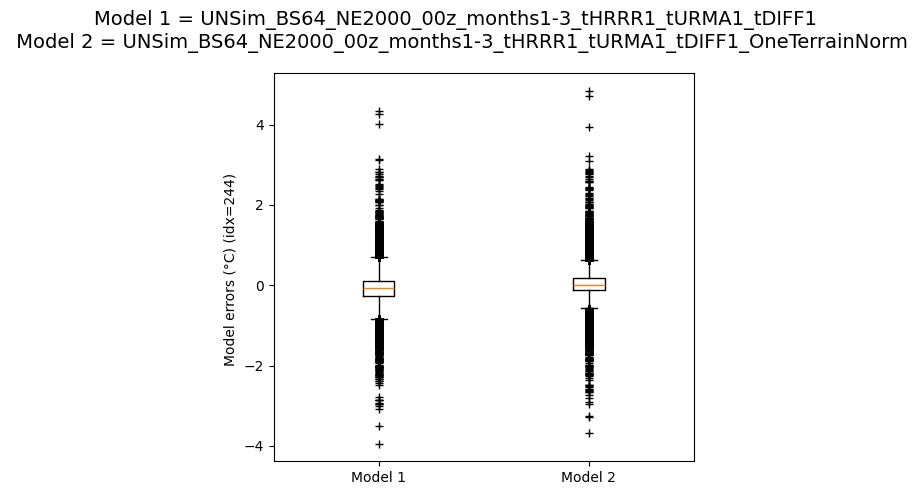

308.51004
224.21777
1.6858454


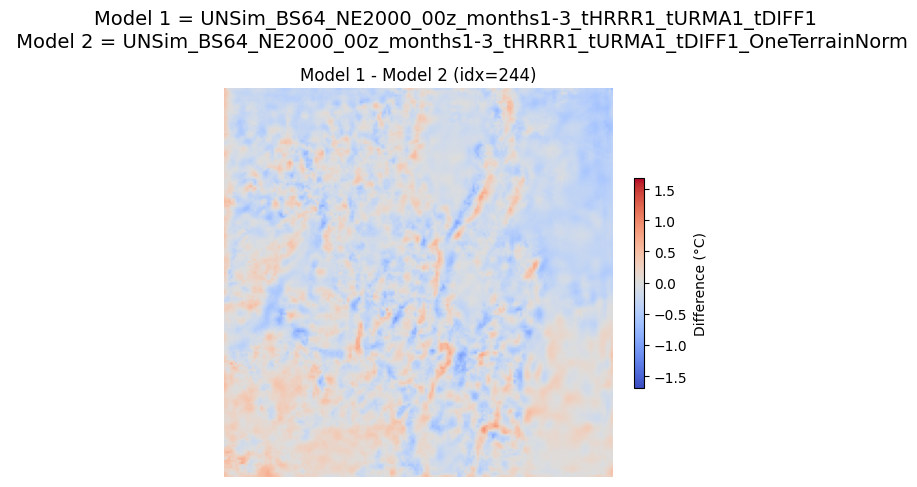

In [42]:
idx = 244 #some random index
X_1,y_1 = train_ds_model_1[idx] 
X_2,y_2 = train_ds_model_2[idx]
X_1 = X_1[np.newaxis,:]
X_2 = X_2[np.newaxis,:]
X_1_gpu = torch.from_numpy(X_1).cuda(device)
X_2_gpu = torch.from_numpy(X_2).cuda(device)

with torch.no_grad():
    pred_1 = pred_model_1(X_1_gpu) #this is different from regular training loop
    pred_2 = pred_model_2(X_2_gpu)
    pred_1 = pred_1.cpu().numpy()
    pred_2 = pred_2.cpu().numpy()

###NOTES: 
#MUST BE COMPARING THE SAME TIME - hence the shared idx in prior code - if the train_ds's start at different times (so indices no longer align from the start), need to be very careful!
#X_1 and X_2 should be identical other than their tensor sizes, if they have different terrains, so just feeding in X_1[0,0,:] for now
#Same for y_1 and y_2
plot_prediction_2models_unnormed(X_1[0,0,:],
                                 y_1,
                                 pred_1,
                                 pred_2,
                                 idx,
                                 train_ds_model_1,
                                 train_ds_model_2,
                                 pred_model_1_name,
                                 pred_model_2_name)

# Make a box plot of the errors for a given idx
y_unnormed = y_1.squeeze()*train_ds_model_1.urma_std + train_ds_model_1.urma_mean
pred_1_unnormed = pred_1.squeeze()*train_ds_model_1.urma_std + train_ds_model_1.urma_mean
pred_2_unnormed = pred_2.squeeze()*train_ds_model_2.urma_std + train_ds_model_2.urma_mean

fig_hist, axes_hist = plt.subplots(1,1, figsize=(5,5))

axes_hist.boxplot([(pred_1_unnormed-y_unnormed).flatten(),(pred_2_unnormed-y_unnormed).flatten()], tick_labels=["Model 1", "Model 2"], sym="+")
plt.ylabel(f"Model errors (°C) (idx={idx}) ")
plt.suptitle(f"Model 1 = {pred_model_1_name} \n Model 2 = {pred_model_2_name}", fontsize=14)
plt.tight_layout()
plt.show()


plot_model1_model2_difference_unnormed(X_1, y_1, pred_1, pred_2, idx, train_ds_model_1, train_ds_model_2, pred_model_1_name, pred_model_2_name)

308.51004
224.21777
1.6858454


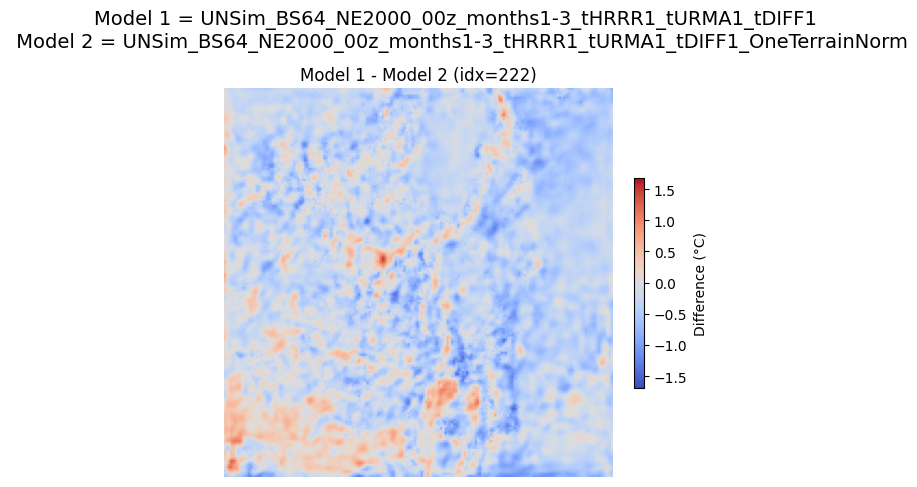

In [13]:
# # Make a box plot of the errors for a given idx
# y_unnormed = y_1.squeeze()*train_ds_model_1.urma_std + train_ds_model_1.urma_mean
# pred_1_unnormed = pred_1.squeeze()*train_ds_model_1.urma_std + train_ds_model_1.urma_mean
# pred_2_unnormed = pred_2.squeeze()*train_ds_model_2.urma_std + train_ds_model_2.urma_mean

# fig_hist, axes_hist = plt.subplots(1,1, figsize=(5,5))

# axes_hist.boxplot([(pred_1_unnormed-y_unnormed).flatten(),(pred_2_unnormed-y_unnormed).flatten()], tick_labels=["Model 1", "Model 2"], sym="+")
# plt.ylabel(f"Model errors (°C) (idx={idx}) ")
# plt.suptitle(f"Model 1 = {pred_model_1_name} \n Model 2 = {pred_model_2_name}", fontsize=14)
# plt.tight_layout()
# plt.show()

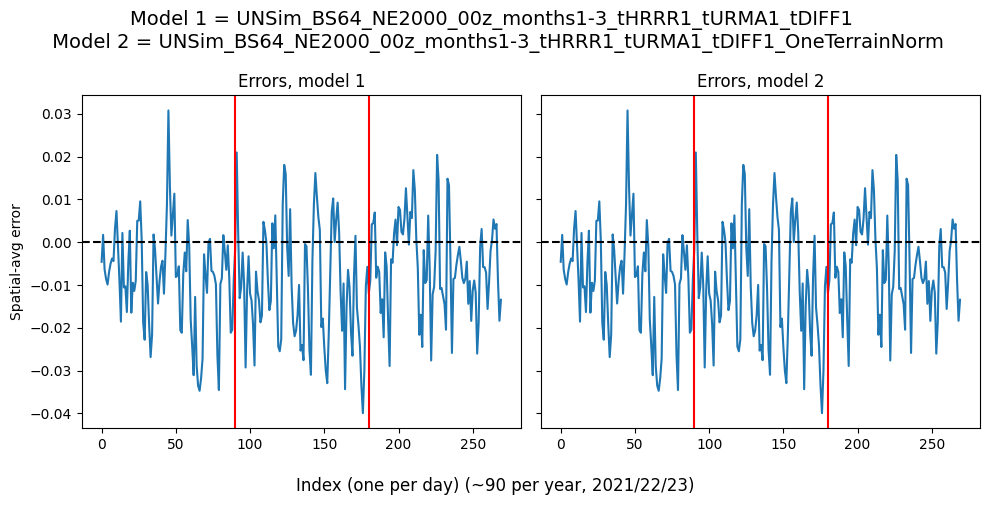

In [15]:
#Assess seasonality distribution of the errors

mean_errors_model_1 = []
mean_errors_model_2 = []

errors_list_model_1 = []
spatial_errors_list_model_1 = []
errors_list_model_2 = []
spatial_errors_list_model_2 = []

for idx, (X,y) in enumerate(train_ds_model_1):
    X = X[np.newaxis,:] 
    X_gpu = torch.from_numpy(X).cuda(device)
    with torch.no_grad():
        pred_1 = pred_model_1(X_gpu) 
        pred_1 = pred_1.cpu().numpy()
    mean_errors_model_1.append(np.mean(pred_1-y))
    y_unnormed_model_1 = y.squeeze()*train_ds_model_1.urma_std + train_ds_model_1.urma_mean
    pred_unnormed_model_1 = pred_1.squeeze()*train_ds_model_1.urma_std + train_ds_model_1.urma_mean
    errors_list_model_1.append((pred_unnormed_model_1-y_unnormed_model_1).flatten())
    spatial_errors_list_model_1.append(pred_unnormed_model_1-y_unnormed_model_1)
    
for idx, (X,y) in enumerate(train_ds_model_2):
    X = X[np.newaxis,:] 
    X_gpu = torch.from_numpy(X).cuda(device)
    with torch.no_grad():
        pred_2 = pred_model_2(X_gpu) 
        pred_2 = pred_2.cpu().numpy()
    mean_errors_model_2.append(np.mean(pred_2-y))
    y_unnormed_model_2 = y.squeeze()*train_ds_model_2.urma_std + train_ds_model_2.urma_mean
    pred_unnormed_model_2 = pred_2.squeeze()*train_ds_model_2.urma_std + train_ds_model_2.urma_mean
    errors_list_model_2.append((pred_unnormed_model_2-y_unnormed_model_2).flatten())
    spatial_errors_list_model_2.append(pred_unnormed_model_2-y_unnormed_model_2)


# for idx, (X,y) in enumerate(train_ds_model_2): 
#     X = X[np.newaxis,:] 
#     X_gpu = torch.from_numpy(X).cuda(device)
#     with torch.no_grad():
#         pred_2 = pred_model_2(X_gpu)
#         pred_2 = pred_2.cpu().numpy()
#     mean_errors_model_2.append(np.mean(pred_2-y))

## Plot made for trained model over 2021-2023 data
#Need to change based on number of months, days in month range, but this is ok approximately
numdays_per_year_model_1 = int(MONTHS_model_1[1]-MONTHS_model_1[0] +1)*30 
numdays_per_year_model_2 = int(MONTHS_model_2[1]-MONTHS_model_2[0] +1)*30

fig2, axes2 = plt.subplots(1,2, figsize=(10,5), sharey=True)
axes2[0].plot(mean_errors_model_1)
axes2[0].set_title("Errors, model 1")
axes2[0].set_ylabel("Spatial-avg error")
axes2[0].vlines(x=numdays_per_year_model_1, ymin = 0, ymax = 1, color = 'red', linestyle = '-', transform=axes2[0].get_xaxis_transform())
axes2[0].vlines(x=2*numdays_per_year_model_1, ymin = 0, ymax = 1, color = 'red', linestyle = '-', transform=axes2[0].get_xaxis_transform())
axes2[0].hlines(y=0, xmin = 0, xmax = 1, color = 'black', linestyle = '--', transform=axes2[0].get_yaxis_transform())

axes2[1].plot(mean_errors_model_1)
axes2[1].set_title("Errors, model 2")
axes2[1].vlines(x=numdays_per_year_model_2, ymin = 0, ymax = 1, color = 'red', linestyle = '-', transform=axes2[1].get_xaxis_transform())
axes2[1].vlines(x=2*numdays_per_year_model_2, ymin = 0, ymax = 1, color = 'red', linestyle = '-', transform=axes2[1].get_xaxis_transform())
axes2[1].hlines(y=0, xmin = 0, xmax = 1, color = 'black', linestyle = '--', transform=axes2[1].get_yaxis_transform())

fig2.suptitle(f"Model 1 = {pred_model_1_name} \n Model 2 = {pred_model_2_name}", fontsize=14)
fig2.supxlabel(f"Index (one per day) (~{numdays_per_year_model_1} per year, 2021/22/23)")
plt.tight_layout()
plt.show()

In [34]:
bp_labels = ["Own Terrain Norm"+f" \n 75%={np.quantile(np.array(errors_list_model_1).flatten(), 0.75):.4f} \n 50%={np.quantile(np.array(errors_list_model_1).flatten(), 0.5):.4f} \n 25%={np.quantile(np.array(errors_list_model_1).flatten(), 0.25):.4f} \n Q3-Q1={(np.quantile(np.array(errors_list_model_1).flatten(), 0.75)-np.quantile(np.array(errors_list_model_1).flatten(), 0.25)):.4f} \n RMSE={np.sqrt(np.mean(np.array(errors_list_model_1).flatten()**2)):.4f}", "URMA Terrain Norm"+f" \n 75%={np.quantile(np.array(errors_list_model_2).flatten(), 0.75):.4f} \n 50%={np.quantile(np.array(errors_list_model_2).flatten(), 0.5):.4f} \n 25%={np.quantile(np.array(errors_list_model_2).flatten(), 0.25):.4f} \n Q3-Q1={(np.quantile(np.array(errors_list_model_2).flatten(), 0.75)-np.quantile(np.array(errors_list_model_2).flatten(), 0.25)):.4f} \n RMSE={np.sqrt(np.mean(np.array(errors_list_model_2).flatten()**2)):.4f}"]


In [29]:
np.array(errors_list_model_1).flatten()**2

array([0.03103868, 0.03020561, 0.01148707, ..., 0.04671023, 0.09773256,
       0.92293173], dtype=float32)

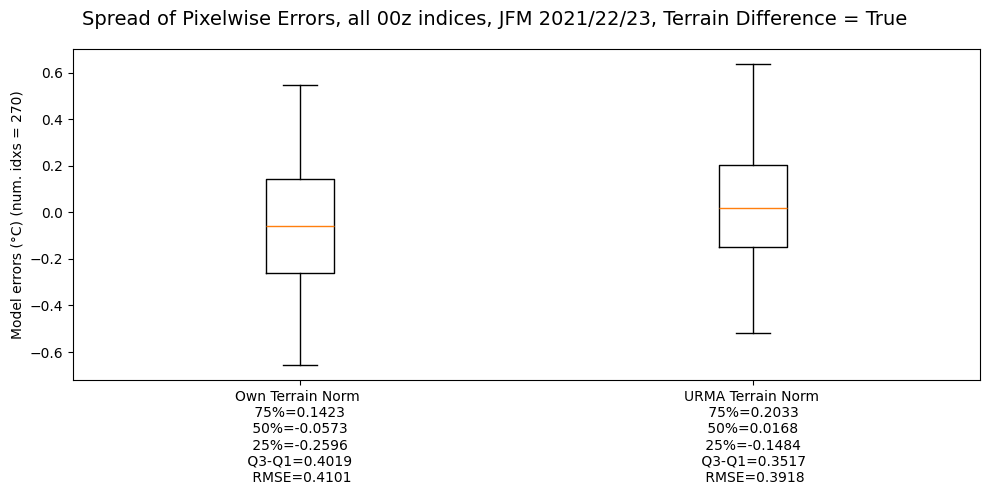

In [36]:
fig_hist, axes_hist = plt.subplots(1,1, figsize=(10,5))

bp = axes_hist.boxplot([np.array(errors_list_model_1).flatten(), np.array(errors_list_model_2).flatten()], tick_labels=bp_labels, sym="", whis=(5,95))
plt.ylabel(f"Model errors (°C) (num. idxs = {idx+1})")# (idx={idx}) ")
plt.suptitle(f"Spread of Pixelwise Errors, all {str(HOUR).zfill(2)}z indices, JFM 2021/22/23, Terrain Difference = {str(bool(W_DIFF_T_model_1))}", fontsize=14)
plt.tight_layout()
plt.show()